In [63]:
from Utils.FS import file
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from scipy.sparse import coo_matrix, dok_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from nltk.corpus import stopwords


In [2]:
np.random.seed(1234)
WINDOW_SIZE = 5
NORM = 'l1'
SVD_DIMENSION = 100

In [3]:
sents = brown.sents()
sents = [[token.lower() for token in sent] for sent in sents]
words = brown.words()
words = [word.lower() for word in words]

In [4]:
print("Number of tokens: {}".format(len(words)))
print("Number of sentences: {}".format(len(sents)))
print("Longest sentences length: {}".format(max([len(sent) for sent in sents])))

Number of tokens: 1161192
Number of sentences: 57340
Longest sentences length: 180


In [5]:
def words2dicts(words):
    f_dict = {}
    index = 0
    for word in words:
        if not word in f_dict.keys():
            f_dict[word] = index
            index = index + 1
        
    return f_dict, { v:k for k, v in f_dict.items()}

In [6]:
words_dict, inv_words_dict = words2dicts(words)
words_size = len(words_dict)
print("Number of unique tokens: {}".format(words_size))

Number of unique tokens: 49815


In [7]:
def singleSideWindow(sents, words_dict, window_size, reverse = False):
    window = []
    row = []
    col = []
    data = []
        
    for sent in reversed(sents) if reverse else sents:
        for word in reversed(sent) if reverse else sent:
            for w in window:
                if w == word:
                    continue
                row.append(words_dict[word])
                col.append(words_dict[w])
                data.append(1)
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    return coo_matrix((data, (row, col)), shape=(len(words_dict), len(words_dict)), dtype='float64')
    

def sents2wordContextMatrix(sents, words_dict, window_size = 5):
    m = coo_matrix((words_size, words_size), 'float64')
    
    print('Doing forward pass...')
    m += singleSideWindow(sents, words_dict, window_size)
    
    print('Doing backward pass...')
    m += singleSideWindow(sents, words_dict, window_size, True)
    
    return m

def sents2wordCoocurrenceMatrix(sents, words_dict, window_size = 10):
    #don't really care edge cases....

    window = []
    row = []
    col = []
    data = []
    for sent in sents:
        for word in sent:
            for i in range(len(window)- 1):
                for j in range(i+1, len(window)):
                    row += [words_dict[window[i]], words_dict[window[j]]]
                    col += [words_dict[window[j]], words_dict[window[i]]]
                    data += [1, 1]
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    print('Preparing sparse matrix...')
    print('Length of data: {}'.format(len(data)))
    return coo_matrix((data, (row,col)), shape=(words_size, words_size), dtype='float64').multiply(1/len(data))

In [8]:
def sents2freq(sents):
    freq = {}
    for sent in sents:
        for word in sent:
            if word in freq.keys():
                freq[word] += 1
            else:
                freq[word] = 1
    return freq

words_freq = sents2freq(sents)

In [69]:
WINDOW_SIZE = 5
m = sents2wordContextMatrix(sents, words_dict, WINDOW_SIZE)

Doing forward pass...
Doing backward pass...


In [70]:
def contextCloud( word):
    vec = m[words_dict[word], :].todense().astype(int)
    text = ""
    freq = {}
    #filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    for i in range(vec.shape[1]):
        if inv_words_dict[i] not in stopwords.words('english'):
            freq[inv_words_dict[i]] = vec[0, i]
            
    wordcloud = WordCloud().generate_from_frequencies(freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

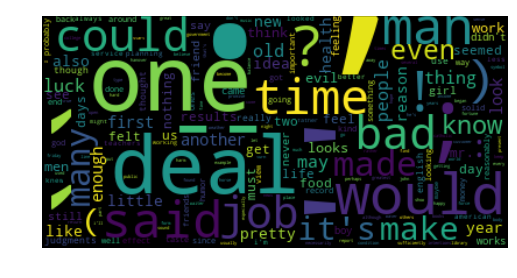

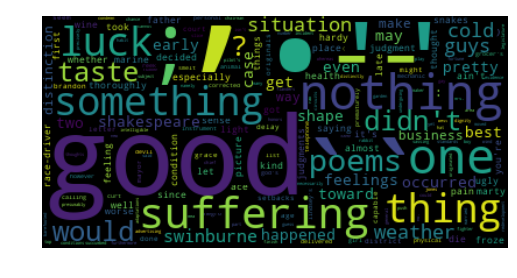

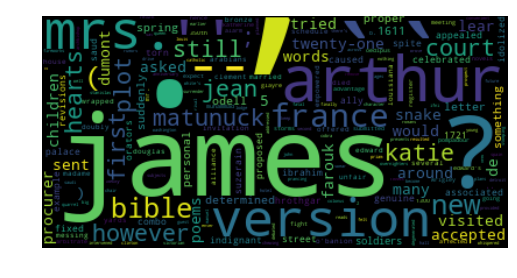

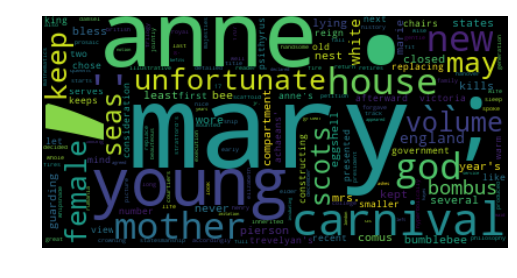

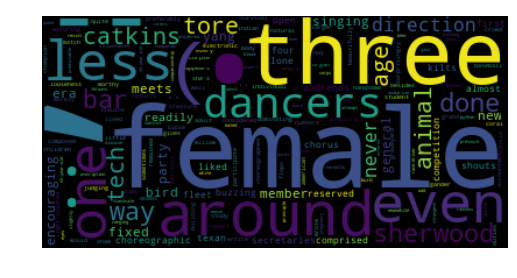

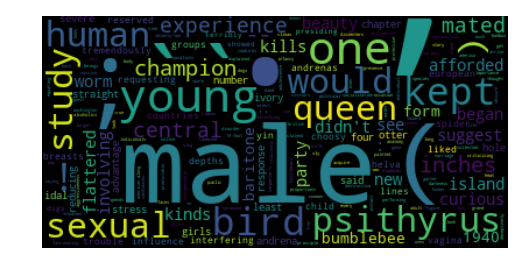

In [71]:
contextCloud('good')
contextCloud('bad')

contextCloud('king')
contextCloud('queen')

contextCloud('male')
contextCloud('female')

In [10]:
#u, s, vt = svds(norm_m, k=SVD_DIMENSION)
SVD_DIMENSION = 10
u, s, vt = svds(m, k=SVD_DIMENSION)
#u, s, vt = svds(co_m, k=SVD_DIMENSION)

norm_u = normalize(np.matmul(u, np.diag(s)), norm='l2', axis=1, copy=True, return_norm=False)

words_vec = {}
for i in range(norm_u.shape[0]):
    words_vec[inv_words_dict[i]] = norm_u[i]

In [11]:
print(words_vec['good'])
print(words_vec['bad'])

np.matmul(words_vec['cat'], words_vec['rocket'].T)

[-0.00226323  0.06718382 -0.0430418   0.03369596 -0.01505091  0.03845135
  0.08967786 -0.03015937  0.04018041  0.99006161]
[ 0.00355159  0.03888225 -0.10403556  0.05037896  0.04126302  0.04264269
  0.11718827  0.00925743 -0.00461544  0.98374437]


0.9498136705618675

In [12]:
def plotData(vocabs, X, Y):
    plt.scatter(X, Y)
    plt.axis([min(X), max(X), min(Y), max(Y)])
    for label, x, y in zip(vocabs, X, Y):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()    

In [13]:
def plot(vocabs, words_vec):
    X = [words_vec[vocab][0] for vocab in vocabs]
    Y = [words_vec[vocab][1] for vocab in vocabs]
    plotData(vocabs, X, Y)

In [14]:
def plotTSNE(vocabs, words_vec):
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    data = np.array([words_vec[vocab] for vocab in vocabs])
    print(data.shape)
    DATA = tsne.fit_transform(data)
    X = DATA[:, 0]
    Y = DATA[:, 1]
    
    plotData(vocabs, X, Y)

In [15]:
vocabs = ['man', 'woman', 'king', 'queen', 'male', 'female', 'boy', 'girl']

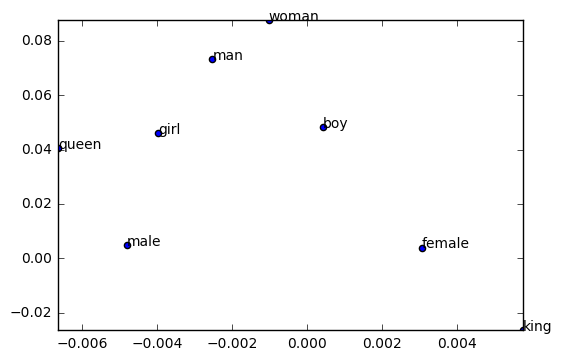

In [16]:
plot(vocabs, words_vec)

In [75]:
from DataLoader import GloVe

glove = GloVe.load2('./data/GloVe/glove.6B.50d.txt')

Start: Loading Glove Model
End: Loaded 400000 rows.


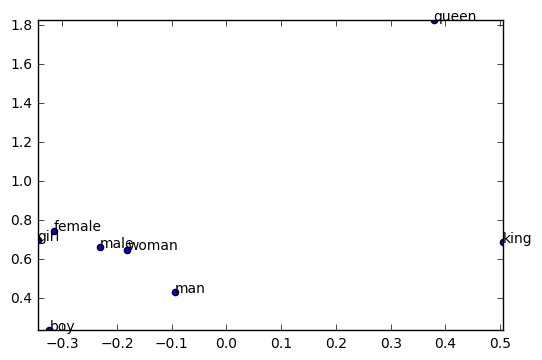

In [ ]:
vocabs = ['man', 'woman', 'king', 'queen', 'male', 'female', 'boy', 'girl']
plot(vocabs, glove)

In [ ]:
plotTSNE(vocabs, glove)